In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#  Generate Synthetic Dataset

X, y = make_classification(n_samples=2000, n_features=10, n_informative=5,
                           n_redundant=2, n_classes=5, n_clusters_per_class=1,
                           random_state=42)

#  Preprocessing
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Data Loaded. Input Shape: {X_train.shape}, Target Shape: {y_train.shape}")

Data Loaded. Input Shape: (1600, 10), Target Shape: (1600, 5)


In [17]:
class ThreeLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(42)
        scale = np.sqrt(2.0 / input_size)

        # Weights for 3 Hidden Layers + 1 Output Layer
        self.weights = {
            'W1': np.random.randn(input_size, hidden_size) * scale,
            'W2': np.random.randn(hidden_size, hidden_size) * scale,
            'W3': np.random.randn(hidden_size, hidden_size) * scale,
            'W4': np.random.randn(hidden_size, output_size) * scale
        }

        self.biases = {
            'b1': np.zeros((1, hidden_size)), 'b2': np.zeros((1, hidden_size)),
            'b3': np.zeros((1, hidden_size)), 'b4': np.zeros((1, output_size))
        }

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):

        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]

        p = np.clip(y_pred, 1e-12, 1. - 1e-12)
        return -np.sum(y_true * np.log(p)) / m

    def forward(self, X):

        self.z1 = np.dot(X, self.weights['W1']) + self.biases['b1']
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.weights['W2']) + self.biases['b2']
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.weights['W3']) + self.biases['b3']
        self.a3 = self.sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.weights['W4']) + self.biases['b4']
        self.a4 = self.softmax(self.z4) # Softmax for multi-class probability
        return self.a4

    def backward(self, X, y, lr):
        m = X.shape[0]


        dZ4 = self.a4 - y
        dW4 = (1/m) * np.dot(self.a3.T, dZ4)
        db4 = (1/m) * np.sum(dZ4, axis=0, keepdims=True)


        dZ3 = np.dot(dZ4, self.weights['W4'].T) * self.sigmoid_derivative(self.a3)
        dW3 = (1/m) * np.dot(self.a2.T, dZ3)
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)

        dZ2 = np.dot(dZ3, self.weights['W3'].T) * self.sigmoid_derivative(self.a2)
        dW2 = (1/m) * np.dot(self.a1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        dZ1 = np.dot(dZ2, self.weights['W2'].T) * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)


        self.weights['W4'] -= lr * dW4; self.biases['b4'] -= lr * db4
        self.weights['W3'] -= lr * dW3; self.biases['b3'] -= lr * db3
        self.weights['W2'] -= lr * dW2; self.biases['b2'] -= lr * db2
        self.weights['W1'] -= lr * dW1; self.biases['b1'] -= lr * db1

    def train(self, X, y, epochs, lr):
        loss_history = []
        for i in range(epochs):
            out = self.forward(X)
            loss = self.cross_entropy_loss(y, out)
            loss_history.append(loss)
            self.backward(X, y, lr)

            if i % 500 == 0:
                print(f"Epoch {i}: Loss {loss:.4f}")
        return loss_history

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

Starting Training...
Epoch 0: Loss 2.3335
Epoch 500: Loss 1.0582
Epoch 1000: Loss 0.7552
Epoch 1500: Loss 0.6237
Epoch 2000: Loss 0.5298
Epoch 2500: Loss 0.4747
Epoch 3000: Loss 0.4417
Epoch 3500: Loss 0.4179
Epoch 4000: Loss 0.3975
Epoch 4500: Loss 0.3788

Final Accuracy: 86.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        81
           1       0.92      1.00      0.96        81
           2       0.77      0.81      0.79        70
           3       0.80      0.76      0.78        79
           4       0.93      0.85      0.89        89

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



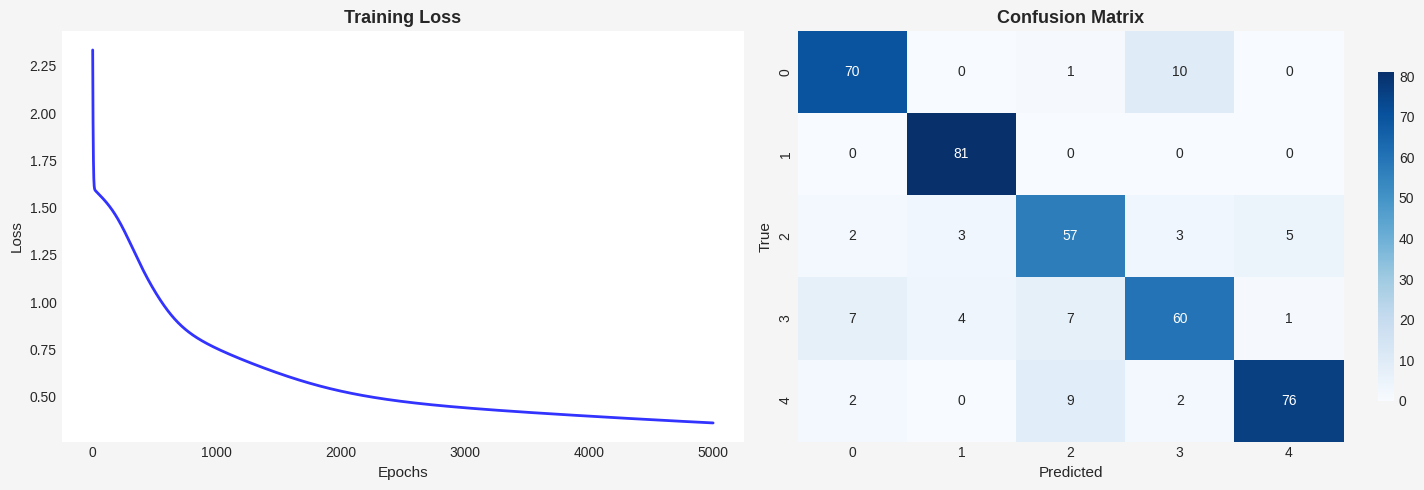

In [26]:
# Configuration
INPUT = 10
HIDDEN = 20
OUTPUT = 5
EPOCHS = 5000
LR = 0.1

#Initialize and Train
model = ThreeLayerNN(INPUT, HIDDEN, OUTPUT)
print("Starting Training...")
history = model.train(X_train, y_train, EPOCHS, LR)

#Evaluation
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor('#f5f5f5')

# Loss Curve
ax1.plot(history, color='blue', linewidth=2, alpha=0.8)
ax1.set_title("Training Loss", fontsize=13, fontweight='bold')
ax1.set_xlabel("Epochs", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('white')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            ax=ax2, cbar_kws={'shrink': 0.8})

ax2.set_title("Confusion Matrix", fontsize=13, fontweight='bold')
ax2.set_xlabel("Predicted", fontsize=11)
ax2.set_ylabel("True", fontsize=11)
ax2.set_facecolor('white')

plt.tight_layout()
plt.show()

**Dataset Overview**

**Goal**: Classify synthetic data into 5 distinct classes using a custom neural network.
**Input**: 10 input features per sample (generated using make_classification).
**Size**: 2000 total samples (1600 for training, 400 for testing).

**Encoding**: Target labels are one-hot encoded using OneHotEncoder to match the neural network's 5 output neurons.

**Model Architecture**

Network Type: 3-layer neural network (3 hidden layers + 1 output layer) with sigmoid activation and softmax output.

Initialization: He initialization to prevent vanishing gradients.

Optimizer: Batch Gradient Descent with learning rate 0.1.

Loss Function: Categorical Cross-Entropy.

**Results and Analysis**

**Performance Analysis:**

Accuracy: The model achieved 86.00% accuracy on the unseen testing data, demonstrating strong classification capability.

Confusion Matrix: The visualization shows a clear diagonal pattern, indicating that the model correctly distinguishes between the 5 classes with minimal confusion between them.

Loss Curve: The training loss shows a steady decrease over 5000 epochs, confirming that the Gradient Descent optimizer successfully minimized the Categorical Cross-Entropy error. The final loss reached 0.3788.

**Classification Report Insights:**

Class 1 showed the best performance with 1.00 recall and 0.92 precision.

Class 2 and Class 3 had slightly lower performance (~0.79-0.80).

All classes had balanced precision and recall values, indicating consistent performance.

**Conclusion & Challenges**

Implementation Success: Successfully built and trained a 3-layer neural network from scratch that can classify data into 5 distinct classes with 86% accuracy.

Key Challenge (Matrix Dimensions): Calculating the backward pass for 4 sets of weights (W1, W2, W3, W4) required careful attention to matrix shapes to ensure the Chain Rule was applied correctly during backpropagation.

Key Challenge (Vanishing Gradients): Deep networks using sigmoid activation can suffer from vanishing gradients if weights are too small or large. This was addressed by implementing He Initialization, which helped maintain stable gradient flow through the network.

**Overall**: The project demonstrates a solid understanding of neural network fundamentals, including forward propagation, backpropagation, loss computation, and gradient-based optimization. The model effectively learned complex patterns in the synthetic dataset despite using a relatively simple architecture.

